The purpose of this notebook is to demonstrate the methods in `methods/mp` and `methods/thomson` for computing nuclear wavefunctions and Franck-Condon factors for diatomic molecules.

In [1]:
import nepc.methods.mp as mp
import nepc.methods.thomson as thomson
from nepc.util.util import get_size
from nepc.util.constants import N2_DIATOMIC_CONSTANTS
from nepc.util.constants import MU_NITROGEN_KG
from nepc.util import scraper
from nepc.util import config
import pdfplumber
import numpy as np
import matplotlib.pyplot as plt

## Reference Franck-Condon Factors

As validation of our computational method, we will compare with available Franck-Condon factors from the literature.

In [2]:
nepcHome = config.nepc_home()
pdfHome = nepcHome + "/ref/angus/"
tmpdir = nepcHome + "/tmp/"

In [3]:
pdfGilmore = scraper.get_pdf(pdfHome + "30_gilmore_j_phys_chem_ref_data_21_1005_1992.pdf")

In [4]:
scraper.rmdir(tmpdir)
scraper.mkdir(tmpdir)

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [6]:
def fcf_extracted_gilmore(pdf, page_number, x_0, column_width, y_0, y_1, vpp_max, locate_tables, debug):
    crop_dim = []
    for i in range(vpp_max + 1):
        crop_dim.append([x_0+i*column_width, y_0, x_0+(i+1)*column_width, y_1])
    fcf_data = []
    for i in range(len(crop_dim)):
        if debug is True: 
            print("vpp: ", str(i))
        dataY = scraper.get_column_strings(pdf=pdfGilmore,
                                           page_number=page_number,
                                           crop_dim_array=crop_dim[i],
                                           locate_tables=locate_tables)
        if locate_tables is False:
            dataY=[s.replace('(', 'E') for s in dataY]
            dataY=[s.replace(')', '') for s in dataY]
            dataY=[s.replace('{', 'E') for s in dataY]
            dataY=[s.replace('}', '') for s in dataY]
            dataY=[s.replace('t', '') for s in dataY]
            dataY=[s.replace(',', '.') for s in dataY]
            dataY=[s.replace("'", '') for s in dataY]
            dataY=[s.replace(' ', '') for s in dataY]
            dataY=[s.replace('*', '') for s in dataY]
            dataY=[s.replace(':', '.') for s in dataY]
            dataY=[s.replace('~', '4') for s in dataY]
            dataY=[s.replace('E-4.', 'E-4') for s in dataY]
            dataY=[s.replace('.5.50E-2', '5.50E-2') for s in dataY]
            dataY=[s.replace('<1E', '4E') for s in dataY]
            dataY=[s.replace('<lE', '4E') for s in dataY]
            dataY=[s.replace('!E', '7E') for s in dataY]
            dataY=[s.replace('E1E', '0E') for s in dataY]
            dataY=[s.replace('8EE', '85E') for s in dataY]
            dataY=[s.replace('OE-I', '0E-1') for s in dataY]
            dataY=[s.replace('SE', '8E') for s in dataY]
            dataY=[s.replace(']E', '1E') for s in dataY]
            dataY=[s.replace('].42E-2', '1.42E-2') for s in dataY]
            dataY=[s.replace('UJ3E-I', '1.03E-1') for s in dataY]            
            dataY=scraper.text_array_to_float_array(dataY)
            fcf_data.append(flatten(dataY))
    if locate_tables is False:
        return fcf_data


In [7]:
"""data_fcf_n2_table_XX stores the FCF's from Gilmore, Table XX"""
data_fcf_n2_table_20 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                  page_number=86,
                                                  x_0=163,
                                                  column_width=47,
                                                  y_0=170,
                                                  y_1=490,
                                                  vpp_max=10,
                                                  locate_tables=False,
                                                  debug=False)

In [8]:
#TODO: scrape remaining Franck-Condon factors for N2 and O2 for comparison

In [9]:
"""data_fcf_n2_table_XX stores the FCF's from Gilmore, Table XX"""
data_fcf_n2_table_28 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                  page_number=92,
                                                  x_0=163,
                                                  column_width=47,
                                                  y_0=170,
                                                  y_1=490,
                                                  vpp_max=10,
                                                  locate_tables=False,
                                                  debug=False)

In [10]:
data_fcf_n2_table_29 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                 page_number=93,
                                                 x_0=170,
                                                 column_width=47,
                                                  y_0=140,
                                                  y_1=450,
                                                 vpp_max=10,
                                                 locate_tables=False,
                                                 debug=False)

In [11]:
data_fcf_n2_table_30 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                 page_number=94,
                                                 x_0=175,
                                                 column_width=47,
                                                  y_0=170,
                                                  y_1=350,
                                                 vpp_max=10,
                                                 locate_tables=False,
                                                 debug=False)

In [12]:
data_fcf_n2_table_31 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                 page_number=95,
                                                 x_0=177,
                                                 column_width=47,
                                                  y_0=160,
                                                  y_1=330,
                                                 vpp_max=10,
                                                 locate_tables=False,
                                                 debug=False)

## Compute Overlap Integrals

As a validation, we can use the FCF code to compute overlap integrals for each state and check to make sure the diagonal elements are one and off-diagonal elements are zero.

In [13]:
#TODO: add remaining constants from NIST website to `nepc/util/constants.py`
#TODO: compute overlap integrals for all states and perform numerical checks below
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2+(X2Sigmag+)'])

In [14]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2(X1Sigmag+)']
vp_list = np.arange(11)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False

In [15]:
Vr_p, Vr_pp, psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list,
                                             vp_list, vpp_list,
                                             jp_list, jpp_list,
                                             diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                             reduced_mass=MU_NITROGEN_KG,
                                             k=17,
                                             delta_r=.5,
                                             psi_p_keep=psi_p_keep,
                                             psi_pp_keep=psi_pp_keep,
                                             dbug=False)

In [16]:
get_size(fcf)

6560

In [17]:
get_size(psi_p)

4196070

In [18]:
get_size(psi_pp)

4196070

In [19]:
psi_p

[{'state': 'N2(X1Sigmag+)',
  'v': 0,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([7.42665204e-49, 7.46925834e-49, 7.51210701e-49, ...,
         1.65855649e-19, 1.65611356e-19, 1.65367418e-19])},
 {'state': 'N2(X1Sigmag+)',
  'v': 5,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([-3.99022991e-45, -4.01293903e-45, -4.03577628e-45, ...,
          4.59658249e-13,  4.59067380e-13,  4.58477256e-13])},
 {'state': 'N2(X1Sigmag+)',
  'v': 10,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([1.36169216e-42, 1.36938338e-42, 1.37711766e-42, ...,
         2.99332482e-08, 2.99008392e-08, 2.98684643e-08])}]

In [20]:
psi_pp

[{'state': 'N2(X1Sigmag+)',
  'v': 0,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([7.42665204e-49, 7.46925834e-49, 7.51210701e-49, ...,
         1.65855649e-19, 1.65611356e-19, 1.65367418e-19])},
 {'state': 'N2(X1Sigmag+)',
  'v': 5,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([-3.99022991e-45, -4.01293903e-45, -4.03577628e-45, ...,
          4.59658249e-13,  4.59067380e-13,  4.58477256e-13])},
 {'state': 'N2(X1Sigmag+)',
  'v': 10,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([1.36169216e-42, 1.36938338e-42, 1.37711766e-42, ...,
         2.99332482e-08, 2.99008392e-08, 2.98684643e-08])}]

In [21]:
print(np.diagonal(fcf[0][0][0][0]))

[1.         1.         1.         1.         1.         1.
 1.         0.99999999 1.00000012 0.99999937 0.99999889]


In [22]:
thomson.off_diagonal_elements(np.array(fcf[0][0][0][0]))

array([2.07603568e-25, 1.24570232e-23, 4.84150440e-26, 3.45324419e-21,
       1.31947181e-22, 8.18378947e-25, 1.67442274e-19, 6.65386853e-23,
       1.24410396e-22, 8.91741651e-24, 5.40230011e-17, 4.92831003e-18,
       8.81605111e-20, 7.90565020e-22, 5.39096031e-22, 5.73745591e-15,
       1.93058267e-16, 6.24318520e-19, 2.15065460e-19, 4.85790980e-20,
       7.92114174e-20, 2.03102493e-14, 6.38749787e-17, 5.13153030e-18,
       2.18187211e-17, 7.46272198e-19, 2.22344527e-17, 1.35334736e-17,
       1.21228068e-12, 3.36367022e-13, 2.92127976e-14, 3.63474982e-18,
       3.76759576e-16, 4.57474002e-16, 1.13556407e-15, 8.06266378e-17,
       3.41789882e-10, 6.40793342e-11, 4.00889941e-12, 6.72421199e-14,
       4.23992872e-14, 1.22057452e-14, 3.92439542e-14, 6.61840999e-16,
       2.47850574e-14, 4.43500209e-08, 1.05886892e-08, 1.00311597e-09,
       4.23275366e-11, 3.87465974e-12, 3.42326178e-13, 1.06886814e-12,
       4.74678828e-14, 9.06822887e-13, 9.21341265e-13, 2.07603568e-25,
      

In [23]:
thomson.rmse_off_diagonal_elements(np.array(fcf[0][0][0][0]))

6.149905670515166e-09

### Incremental RMSE

We can compute the RMSE as a function of v' to see how the cumulative error grows as we increase the number of vibrational levels.

In [24]:
thomson.incremental_rmse_off_diagonal_elements(np.array(fcf[0][0][0][0]))

i: 2; rmse: 2.0760356823816384e-25
i: 3; rmse: 7.193118734674784e-24
i: 4; rmse: 1.4108189948268802e-21
i: 5; rmse: 5.296119106032183e-20
i: 6; rmse: 1.4006685817342757e-17
i: 7; rmse: 1.2527800518910035e-15
i: 8; rmse: 3.988689825011654e-15
i: 9; rmse: 2.0976625459968608e-13
i: 10; rmse: 5.18425283158353e-11
i: 11; rmse: 6.149905670515166e-09


In [25]:
thomson.incremental_rmse_diagonal_elements(np.array(fcf[0][0][0][0]))

i: 1; rmse: 1.2878587085651816e-14
i: 2; rmse: 5.849263503687179e-14
i: 3; rmse: 8.686684631602317e-14
i: 4; rmse: 2.04829378278883e-13
i: 5; rmse: 8.531160311515375e-12
i: 6; rmse: 2.1598630779227068e-11
i: 7; rmse: 7.047727789621915e-10
i: 8; rmse: 2.5768960439446153e-09
i: 9; rmse: 3.9921286262981266e-08
i: 10; rmse: 2.040927898088337e-07
i: 11; rmse: 3.880010835321035e-07


In [26]:
np.diagonal(np.array(fcf[0][0][0][0]))-1

array([-1.28785871e-14,  8.17124146e-14, -1.25677246e-13, -3.81028542e-13,
       -1.90718552e-11,  4.93467489e-11, -1.86390281e-09, -7.04600689e-09,
        1.19541870e-07, -6.34188684e-07, -1.11330795e-06])

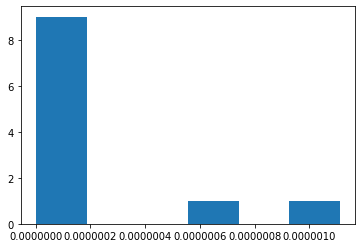

In [27]:
fcf_diagonal_error = np.sqrt((np.diagonal(np.array(fcf[0][0][0][0]))-1)**2)
# histogram on linear scale
#plt.subplot(311)
hist, bins, _ = plt.hist(fcf_diagonal_error, bins=6)

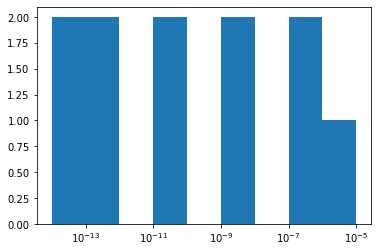

In [28]:
# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
bin_first = round(np.log10(bins[0]))
bin_last = round(np.log10(bins[-1])+1)
logbins = np.logspace(bin_first, bin_last, abs(bin_first) - abs(bin_last)+1)
#plt.subplot(312)
plt.hist(fcf_diagonal_error, bins=logbins)
plt.xscale('log')
plt.show()

### Check of delta_r

We can visually inspect plots of psi_p, psi_pp, and psi_p x psi_pp for the highest vibrational modes to ensure that we have captured the entire wavefunction (but haven't made the integration limits too large).

In [29]:
psi_0 = psi_p[1]['psi_r']
r_array_0 = psi_p[1]['r_array']
psi_1 = psi_p[2]['psi_r']
r_array_1 = psi_p[2]['r_array']
psi_0_1 = psi_0 * psi_1

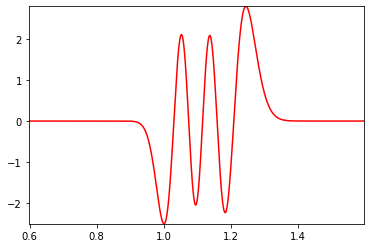

In [30]:
plt.plot(r_array_0,psi_0, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0), max(psi_0)])
plt.show()

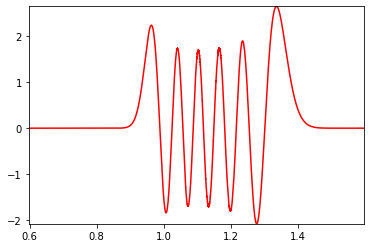

In [31]:
plt.plot(r_array_1, psi_1, 'r')
plt.axis([min(r_array_1), max(r_array_1), min(psi_1), max(psi_1)])
plt.show()

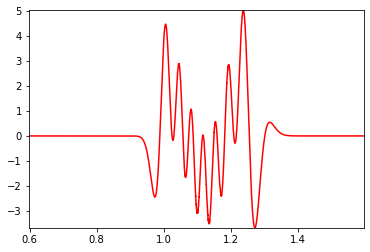

In [32]:
plt.plot(r_array_0, psi_0_1, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0_1), max(psi_0_1)])
plt.show()

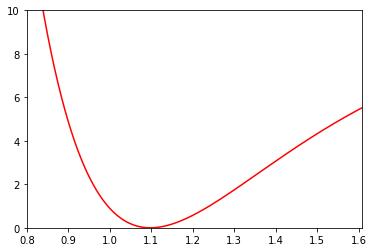

In [69]:
from numpy import exp

def Vr_array(Vr_p, r_array):
    return (Vr_p['De']/8065.6)*(1.0 - exp(-Vr_p['a']*(r_array - Vr_p['re'])))**2

Vr_p_array = Vr_array(Vr_p[0], r_array_0)

plt.plot(r_array_0, Vr_p_array, 'r')
plt.axis([.8, max(r_array_0), 0, 10])
plt.show()

## FCFs

Now, we compute FCFs for the case where p' and p'' differ, compare with Gilmore's results, and also look at closure relationships.

In [33]:
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2+(X2Sigmag+)'])

In [34]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2(B3Pig)']
vp_list = np.arange(11)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False

In [36]:
Vr_p, Vr_pp, psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list,
                                 vp_list, vpp_list,
                                 jp_list, jpp_list,
                                 diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                 reduced_mass=MU_NITROGEN_KG,
                                 k=17,
                                 delta_r=.5,
                                 psi_p_keep=psi_p_keep,
                                 psi_pp_keep=psi_pp_keep,
                                 dbug=False)

In [37]:
for i in range(len(fcf[0][0][0][0])):
    print('\nv\'/v\'\': {}'.format(i))
    for j in range(len(fcf[0][0][0][0][0])):
        print('{}\t{:.2E}\t{:.2E}'.format(j, data_fcf_n2_table_20[i][j], fcf[0][0][0][0][i][j]))



v'/v'': 0
0	6.11E-02	4.21E-02
1	1.47E-01	1.08E-01
2	1.95E-01	1.56E-01
3	1.90E-01	1.68E-01
4	1.51E-01	1.51E-01
5	1.05E-01	1.20E-01
6	6.65E-02	8.81E-02
7	3.90E-02	6.06E-02
8	2.16E-02	3.99E-02
9	1.15E-02	2.54E-02
10	5.92E-03	1.58E-02

v'/v'': 1
0	1.91E-01	1.58E-01
1	1.93E-01	1.93E-01
2	6.54E-02	1.00E-01
3	7.17E-04	1.79E-02
4	2.58E-02	1.51E-03
5	7.60E-02	2.81E-02
6	1.04E-01	6.07E-02
7	1.03E-01	7.95E-02
8	8.39E-02	8.18E-02
9	6.04E-02	7.29E-02
10	3.98E-02	5.92E-02

v'/v'': 2
0	2.74E-01	2.64E-01
1	4.50E-02	7.74E-02
2	2.39E-02	3.03E-03
3	1.05E-01	6.86E-02
4	8.38E-02	9.33E-02
5	2.07E-02	5.52E-02
6	5.33E-04	1.29E-02
7	2.49E-02	1.16E-04
8	5.85E-02	1.27E-02
9	7.72E-02	3.36E-02
10	7.73E-02	4.99E-02

v'/v'': 3
0	2.41E-01	2.60E-01
1	1.59E-02	2.52E-03
2	1.30E-01	1.13E-01
3	3.60E-02	6.92E-02
4	7.32E-03	1.52E-03
5	6.56E-02	2.44E-02
6	7.50E-02	6.24E-02
7	3.34E-02	6.01E-02
8	2.39E-03	3.13E-02
9	6.14E-03	6.72E-03
10	3.00E-02	1.62E-04

v'/v'': 4
0	1.44E-01	1.68E-01
1	1.42E-01	1.16E-01
2	4.81E-02	7.81E-02
3

These calculated FCF's appear to be fairly close to Gilmore's results, especially for v', v'' < 5.

In [38]:
thomson.rmse_calc_ref(np.array(fcf[0][0][0][0]), data_fcf_n2_table_20)

0.02205500772357083

In [39]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2+(X2Sigmag+)']
vp_list = np.arange(11)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False

In [41]:
Vr_p, Vr_pp, psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list,
                                 vp_list, vpp_list,
                                 jp_list, jpp_list,
                                 diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                 reduced_mass=MU_NITROGEN_KG,
                                 k=17,
                                 delta_r=.5,
                                 psi_p_keep=psi_p_keep,
                                 psi_pp_keep=psi_pp_keep,
                                 dbug=False)

In [42]:
thomson.print_fcf_calc_ref(fcf[0][0][0][0], data_fcf_n2_table_28)


v'/v'': 0
0	9.17E-01	9.11E-01
1	7.79E-02	8.58E-02
2	4.65E-03	3.09E-03
3	2.68E-04	1.22E-05
4	1.76E-05	6.41E-06
5	1.55E-06	2.16E-06
6	2.13E-07	2.58E-07
7	4.74E-08	1.57E-08
8	1.47E-08	3.23E-10
9	5.49E-09	1.97E-10
10	2.24E-09	2.83E-11

v'/v'': 1
0	8.02E-02	8.31E-02
1	7.60E-01	7.42E-01
2	1.45E-01	1.64E-01
3	1.38E-02	1.03E-02
4	1.12E-03	1.06E-04
5	9.62E-05	2.11E-05
6	1.06E-05	1.16E-05
7	1.71E-06	1.87E-06
8	4.21E-07	1.54E-07
9	1.42E-07	5.55E-09
10	5.67E-08	6.61E-11

v'/v'': 2
0	2.53E-03	5.60E-03
1	1.54E-01	1.55E-01
2	6.12E-01	5.85E-01
3	2.01E-01	2.32E-01
4	2.72E-02	2.24E-02
5	2.89E-03	4.55E-04
6	3.14E-04	3.59E-05
7	4.18E-05	3.52E-05
8	7.79E-06	7.52E-06
9	2.11E-06	8.15E-07
10	7.58E-07	3.89E-08

v'/v'': 3
0	4.47E-05	1.81E-04
1	7.91E-03	1.67E-02
2	2.21E-01	2.13E-01
3	4.75E-01	4.42E-01
4	2.44E-01	2.87E-01
5	4.45E-02	3.98E-02
6	6.00E-03	1.37E-03
7	7.97E-04	3.66E-05
8	1.25E-04	7.83E-05
9	2.65E-05	2.21E-05
10	7.79E-06	3.11E-06

v'/v'': 4
0	4.17E-07	5.01E-06
1	2.04E-04	7.57E-04
2	1.65E-02	3.29E-02
3

In [43]:
thomson.rmse_calc_ref(np.array(fcf[0][0][0][0]), data_fcf_n2_table_28)

0.03537179410494537

A check of the closure relationship.

#TODO: explain this; what does it mean exactly?

In [44]:
thomson.fcf_closure(fcf[0][0][0][0])

v'	closure_vp
0	1.0000000001767329
1	0.9999999998728245
2	0.9999999954554233
3	0.9999997879563965
4	0.9999896993081375
5	0.9998664036251703
6	0.9994862758363499
7	0.9988741824596544
8	0.9646437257821843
9	0.740027458942998
10	0.45917206327568294

v''	closure_vpp
0	1.0000000547447505
1	1.0000000015314268
2	0.999999999905775
3	0.9999999995889112
4	1.0000000015433683
5	0.9999992408724231
6	0.9999555975988051
7	0.9974206960639337
8	0.9585597073313424
9	0.7226200622109555
10	0.48350423129986314


In [45]:
psi_0 = psi_p[2]['psi_r']
r_array_0 = psi_p[2]['r_array']
psi_1 = psi_pp[2]['psi_r']
r_array_1 = psi_pp[2]['r_array']
psi_0_1 = psi_0 * psi_1

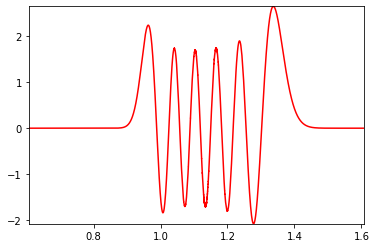

In [46]:
plt.plot(r_array_0,psi_0, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0), max(psi_0)])
plt.show()

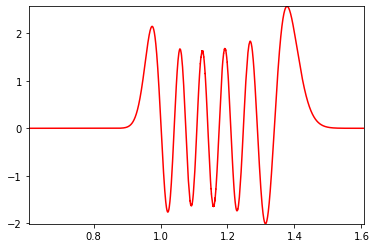

In [47]:
plt.plot(r_array_1, psi_1, 'r')
plt.axis([min(r_array_1), max(r_array_1), min(psi_1), max(psi_1)])
plt.show()

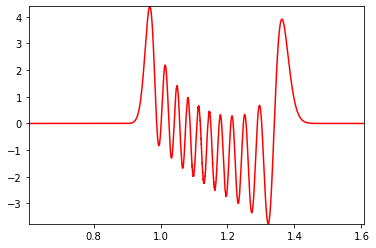

In [48]:
plt.plot(r_array_0, psi_0_1, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0_1), max(psi_0_1)])
plt.show()

In [49]:
thomson.fcf_closure(fcf[0][0][0][0])

v'	closure_vp
0	1.0000000001767329
1	0.9999999998728245
2	0.9999999954554233
3	0.9999997879563965
4	0.9999896993081375
5	0.9998664036251703
6	0.9994862758363499
7	0.9988741824596544
8	0.9646437257821843
9	0.740027458942998
10	0.45917206327568294

v''	closure_vpp
0	1.0000000547447505
1	1.0000000015314268
2	0.999999999905775
3	0.9999999995889112
4	1.0000000015433683
5	0.9999992408724231
6	0.9999555975988051
7	0.9974206960639337
8	0.9585597073313424
9	0.7226200622109555
10	0.48350423129986314
